Try below changes to improve the performance.

1. Change the number of Epochs.

2. Change the batch size Large or Small.

3. Change the number of Model in hidden layers.

4. Change the number of Layers.

5. Change the activation Function from ReLU to something else.

6. Add a regularization function such as dropout or Batch normalization.


In [3]:
#Import dataset

import math
import numpy as np
import chainer
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [6]:
#Prepare the DATASET 
from __future__ import print_function
import matplotlib.pyplot as plt
from chainer.datasets import mnist

#Download the MNIST data
train, test = mnist.get_mnist(withlabel=True, ndim=1)

#Display example from MNIST 
#'x' contains the input image array and 't' contains that target class
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.savefig('input.png')
print('label : ', t)

label :  5


In [3]:
#Create a dataset Iterator

from chainer import iterators
#choose the minibatch size
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)


### Create your network as a subclass of Chain


In [4]:
class MyNetwork(Chain):
    
    def __init__(self, n_mid_units = 100, n_out = 10):
        super(MyNetwork, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units , n_out)
    
    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        return self.l3(h)

model = MyNetwork()
gpu_id = -1 #Set 0 for GPU

if gpu_id >= 0:
    model.to_gpu(gpu_id)
    

### 4. Select an optimization algorithm

What is Gradient Descent?
Before talking about Stochastic Gradient Descent (SGD), let’s first understand what is Gradient Descent? Gradient Descent is a very popular optimization technique in Machine Learning and Deep Learning and it can be used with most, if not all, of the learning algorithms. A gradient is basically the slope of a function; the degree of change of a parameter with the amount of change in another parameter. Mathematically, it can be described as the partial derivatives of a set of parameters with respect to its inputs. The more the gradient, the steeper the slope. Gradient Descent is a convex function.
Gradient Descent can be described as an iterative method which is used to find the values of the parameters of a function that minimizes the cost function as much as possible. The parameters are initially defined a particular value and from that, Gradient Descent is run in an iterative fashion to find the optimal values of the parameters, using calculus, to find the minimum possible value of the given cost function.

Types of Gradient Descent:

Typically, there are three types of Gradient Descent:

1. Batch Gradient Descent
2. Stochastic Gradient Descent
3. Mini-batch Gradient Descent

In [7]:
from chainer import optimizers
# choose an optimizer algorithm
optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)
#Give the optimizer a referance to the model so, that it can locate the model paramenter
optimizer.setup(model)

We set 'lr' to 0.01 in the constructor. This value is known as the “learning rate”, one of the most important hyperparameters that need to be adjusted in order to obtain the best performance. 

### 5. Write a training loop

In [12]:
from chainer.dataset import concat_examples
from chainer.backends.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:
    
    #---------one iterator of the tranning loop-----------------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, gpu_id)
    
     # Calculate the prediction of the network
    prediction_train = model(image_train)
    
    #Calculate the loss with softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)
    
    #Calculate the gradients in the network
    model.cleargrads()
    loss.backward()
    
    #Update all the trainable parameters
    optimizer.update()
    
    #Check the validation accuracy after every epoch
    if train_iter.is_new_epoch: # If this iteration is the final iteration of the current epoch
        #Display the tranning loss
        print('epoch:{:02d} train_loss: {:.04f}'.format(train_iter.epoch, float(to_cpu(loss.array))), end='')
        
        test_losses = []
        test_accuracies = []
        for test_batch in test_iter:
            image_test, target_test = concat_examples(test_batch, gpu_id)
            # Forward the test data
            prediction_test = model(image_test)

            # Calculate the loss
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.array))

            # Calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.array)

        test_iter.reset()

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))
            

epoch:01 train_loss: 0.2307val_loss:0.2607 val_accuracy:0.9257
epoch:02 train_loss: 0.2071val_loss:0.1926 val_accuracy:0.9438
epoch:03 train_loss: 0.1931val_loss:0.1577 val_accuracy:0.9523
epoch:04 train_loss: 0.1625val_loss:0.1293 val_accuracy:0.9605
epoch:05 train_loss: 0.0386val_loss:0.1145 val_accuracy:0.9645
epoch:06 train_loss: 0.2264val_loss:0.1106 val_accuracy:0.9655
epoch:07 train_loss: 0.0499val_loss:0.0942 val_accuracy:0.9710
epoch:08 train_loss: 0.0955val_loss:0.0925 val_accuracy:0.9713
epoch:09 train_loss: 0.0240val_loss:0.0893 val_accuracy:0.9721
epoch:10 train_loss: 0.0825val_loss:0.0874 val_accuracy:0.9728


### 6. Save the trained model
Chainer provides two types of serializers that can be used to save and restore model state. One supports the HDF5 format and the other supports the NumPy NPZ format. For this example, we are going to use the NPZ format to save our model since it is easy to use with NumPy and doesn’t need to install any additional dependencies or libraries.

In [13]:
serializers.save_npz('my_mnist_model.model', model)

### 7. Perform classification by the saved model
Let’s use the saved model to classify a new image. In order to load the trained model parameters, we need to perform the following two steps:

1. Instantiate the same network as what you trained.

2. Overwrite all parameters in the model instance with the saved weights using the load_npz() function.

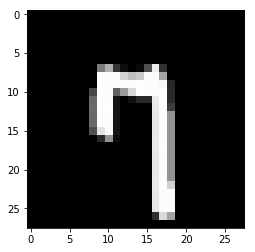

Label :  7


In [8]:
from chainer import serializers

#Create an instance of the network you trained
model = MyNetwork()

#Load the saved paramenter into instance
serializers.load_npz('my_mnist_model.model', model)

#Get a test image and label
x, t = test[80]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('Label : ',t)

In [2]:
import chainer
help(chainer.config)

Help on LocalConfig in module chainer.configuration object:

class LocalConfig(builtins.object)
 |  LocalConfig(global_config)
 |  
 |  Thread-local configuration of Chainer.
 |  
 |  This class implements the local configuration. When a value is set to this
 |  object, the configuration is only updated in the current thread. When a
 |  user tries to access an attribute and there is no local value, it
 |  automatically retrieves a value from the global configuration.
 |  
 |  Methods defined here:
 |  
 |  __delattr__(self, name)
 |      Implement delattr(self, name).
 |  
 |  __getattr__(self, name)
 |  
 |  __init__(self, global_config)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __setattr__(self, name, value)
 |      Implement setattr(self, name, value).
 |  
 |  show(self, file=<ipykernel.iostream.OutStream object at 0x00000217740885F8>)
 |      show(file=sys.stdout)
 |      
 |      Prints the config entries.
 |      
 |      The entries are sor

In [8]:
a = lambda x : x*x if x<=2 else x
a(3)

3